In [1]:
%matplotlib inline
from pprint import pprint
from collections import defaultdict

import numpy as np
import math
import matplotlib.pyplot as plt
import random
import warnings

import sklearn.tree
import sklearn.ensemble

from sklearn.grid_search import GridSearchCV
from sklearn import metrics

import sys
sys.path.append('../dev')

from ml_plot import plot_validation_curve
from ml_plot import PredictCV, my_plot_learning_curve
from ml_plot import plot_prediction_curve
from ml_plot import get_dataset, eval_predictions

# Configuration

In [2]:
PROJECT = 'nova'
# PROJECT = 'swift'
# PROJECT = 'cinder'
# PROJECT = 'heat'
# PROJECT = 'glance'

# IMPORTANCE = 'crit'
# IMPORTANCE = 'high+'
IMPORTANCE = 'med+'
# IMPORTANCE = 'low+'

# SIZE = 100
#SIZE = 250
# SIZE = 0.1
SIZE = 0.5

SCORING = 'f1'         # (precision * recall) / (precision + recall)
# SCORING = 'accuracy'   # (TP + TN) / all values
# SCORING = 'precision'  # TP / (TP + FP)
# SCORING = 'recall'     # TP / (TP + FN)
# SCORING = 'average_precision'
# SCORING = 'roc_auc'

JOBS = 4

VERBOSE = 0

#warnings.simplefilter("ignore", UndefinedMetricWarning)
warnings.filterwarnings("ignore", 'F-score is ill-defined')

# Load Data

In [3]:
# %%capture
Y, X = get_dataset(PROJECT, IMPORTANCE)

loading bug data
  total LP bugs: 6828
  Entries annotated: 3207
loading Git commit data
  total git_commits: 33568
  bug fix commits: 4796
  commits with change_id: 11738
  bug fix with change_id: 4533
loading change data
  total gerrit changes with detail: 12885
  all_change_details: 12885
  total gerrit changes: 12907
  all_changes: 12907
combined_commits: 33568
Determining legacy cut-off
  Transition interval: 5:38:41
  Parent of first_with: 853aad905531fbdf6d5ddce4bc26b3caeebbc49f
  Setting cutoff to: 22/09/2011
  Mainline Commits ignored due to legacy: 1616  out of: 13296
  Total commite requiring blame computation: 2801

Computing Blame
Failed to load blame
  Initial Blame cache size: 0
  bug fix commits: 2801
. . . . . . . . . . 100 . . . . . . . . . . 200 . . . . . . . . . . 300 . . . . . . . . . . 400 . . . . . . . . . . 500 . . . . . . . . . . 600 . . . . . . . . . . 700 . . . . . . . . . Skipping empty token A153_B179_insert
. 800 . . . . . . . . . . 900 . . . . . . . . . .

### Select Split Strategy

In [4]:
cv = PredictCV(len(Y), history=500, future=500, n_iter=100)

# Random Forest

In [5]:
estimator = sklearn.ensemble.RandomForestClassifier()
param_grid = {'criterion': ['gini', 'entropy'],
                  'n_estimators':[5, 10, 15],
                  'max_features':['auto', 'log2', 10, 25, 50, 75, 100, 150, 200]  }

In [6]:
grid = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=SCORING,
                    n_jobs=JOBS, pre_dispatch=2*JOBS, verbose=VERBOSE)
# grid.fit(X_train, Y_train)
grid.fit(X, Y)
print 'best_score: ', grid.best_score_
clf = grid.best_estimator_
grid.best_estimator_

best_score:  0.379879566745


RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features=200,
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

### Validation Curve

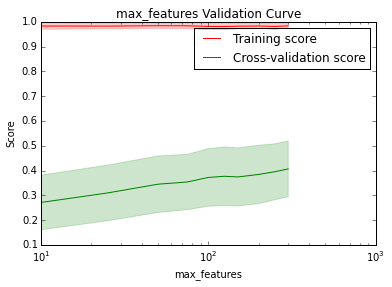

In [7]:
best_score, param_val, param_name = \
    plot_validation_curve(clf,
                          # X_train, Y_train,
                          X, Y,
                          "max_features", [10, 25, 50, 75, 100, 125, 150, 200, 250, 300],
                          "max_features Validation Curve",
                          cv=cv, scoring=SCORING, n_jobs=JOBS)

In [8]:
print 'Best score of', best_score, 'when setting', param_name, 'to',  param_val

Best score of 0.407078631093 when setting max_features to 300


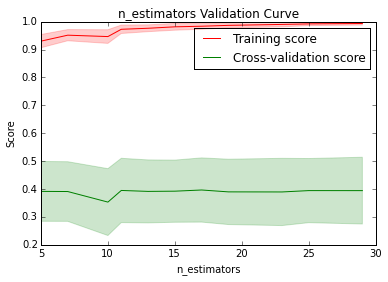

In [9]:
best_score, param_val, param_name = \
    plot_validation_curve(clf,
                          # X_train, Y_train,
                          X, Y,
                          "n_estimators", [5, 7, 10, 11, 13, 15, 17, 19, 23, 25, 29],
                          "n_estimators Validation Curve",
                          cv=cv, scoring=SCORING, n_jobs=JOBS, scale='linear')

In [10]:
print 'Best score of', best_score, 'when setting', param_name, 'to',  param_val

Best score of 0.396751761058 when setting n_estimators to 17


### Learning Curve

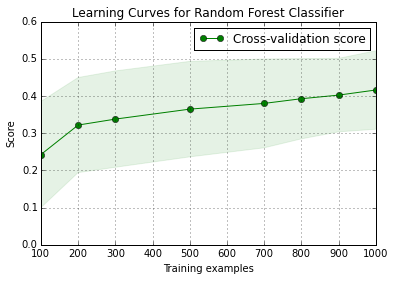

In [11]:
title = "Learning Curves for Random Forest Classifier"
my_plot_learning_curve(clf, title, X, Y,
                           n_jobs=JOBS, future=500,
                           history_sizes=[100, 200, 300, 500, 700, 800, 900, 1000], n_iter=100)
plt.show()

### Prediction Curve

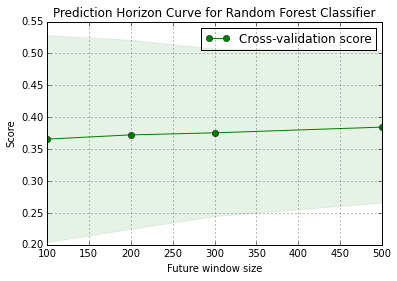

In [12]:
title = "Prediction Horizon Curve for Random Forest Classifier"
plot_prediction_curve(clf, title, X, Y,
                           n_jobs=JOBS, history=500,
                           future_sizes=[100, 200, 300, 500], n_iter=100)
plt.show()

In [13]:
RF_results = eval_predictions(clf, X, Y, history_sizes=[300, 700, 500, 1000], future_sizes=[100, 150, 200, 500], n_iter=100)

** Predictions for hist=300 future=100 **

F1:        0.34  +/- 0.19
Accuracy:  0.79  +/- 0.07
Precision: 0.52  +/- 0.26
Recall:    0.27  +/- 0.17

Aggregate Confusion Matrix - 100 iterations
[[7240  475]
 [1581  704]]


** Predictions for hist=300 future=150 **

F1:        0.32  +/- 0.15
Accuracy:  0.80  +/- 0.07
Precision: 0.57  +/- 0.23
Recall:    0.24  +/- 0.14

Aggregate Confusion Matrix - 100 iterations
[[11055   625]
 [ 2418   902]]


** Predictions for hist=300 future=200 **

F1:        0.36  +/- 0.14
Accuracy:  0.79  +/- 0.06
Precision: 0.58  +/- 0.16
Recall:    0.29  +/- 0.14

Aggregate Confusion Matrix - 100 iterations
[[14319  1052]
 [ 3178  1451]]


** Predictions for hist=300 future=500 **

F1:        0.32  +/- 0.14
Accuracy:  0.80  +/- 0.05
Precision: 0.57  +/- 0.14
Recall:    0.24  +/- 0.12

Aggregate Confusion Matrix - 100 iterations
[[37159  2069]
 [ 7885  2887]]


** Predictions for hist=700 future=100 **

F1:        0.37  +/- 0.17
Accuracy:  0.79  +/- 0.06
Precision

/Users/doug/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
RF_clf = clf